# Task 2: Building the baseline model

In [7]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [ ]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product
from sklearn.metrics import confusion_matrix

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
import importlib
import seaborn as sns

from src.preprocessing import get_image_generator
from src.models import custom_CNN

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [ ]:
# Set up your Image Generators for the training, validation, and test data.
img_height, img_width = 299, 299
channels = 3
batch_size = 100

path_train = "../data/train"
path_val = "../data/val"
path_test = "../data/test"

train_data_gen = get_image_generator(path_train, img_height, img_width, batch_size, shuffle=True, preprocess=True)
val_data_gen = get_image_generator(path_val, img_height, img_width, batch_size, shuffle=False, preprocess=False)
test_data_gen = get_image_generator(path_test, img_height, img_width, batch_size, shuffle=False, preprocess=False)

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Initial model

In [10]:
# Set up the classification
metrics=['accuracy']

In [ ]:
model = custom_CNN(
    (img_height, img_width, channels),
    dropout_rate = 0.001,
    filters = 16,
    dense_unit = 512)

# Create optimizer with the given learning rate.
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)
model.compile(optimizer=optimizer,
                loss=tf.keras.losses.BinaryCrossentropy(),
                metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 299, 299, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 149, 149, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 74, 74, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 87616)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    44,859,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,884,001 (171.22 MB)

 Trainable params: 44,884,001 (171.22 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
total_train = train_data_gen.samples
total_val = val_data_gen.samples

print(f"total_train: {total_train}")
print(f"total_val: {total_val}")
print(f"batch_size: {batch_size}")
print(f"steps_per_epoch: {total_train // batch_size}")

total_train: 1600
total_val: 400
batch_size: 100
steps_per_epoch: 16


In [13]:
epochs = 2

history = model.fit(
    train_data_gen,
    batch_size=batch_size,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=total_val // batch_size
)

c:\ProgramData\anaconda3\envs\ai_project\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 102s 6s/step - accuracy: 0.5393 - loss: 2.6253 - val_accuracy: 0.6150 - val_loss: 0.6843
Epoch 2/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.6899 - loss: 0.6389 - val_accuracy: 0.6325 - val_loss: 0.6580
Epoch 3/3
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.6849 - loss: 0.6097 - val_accuracy: 0.6200 - val_loss: 0.6679


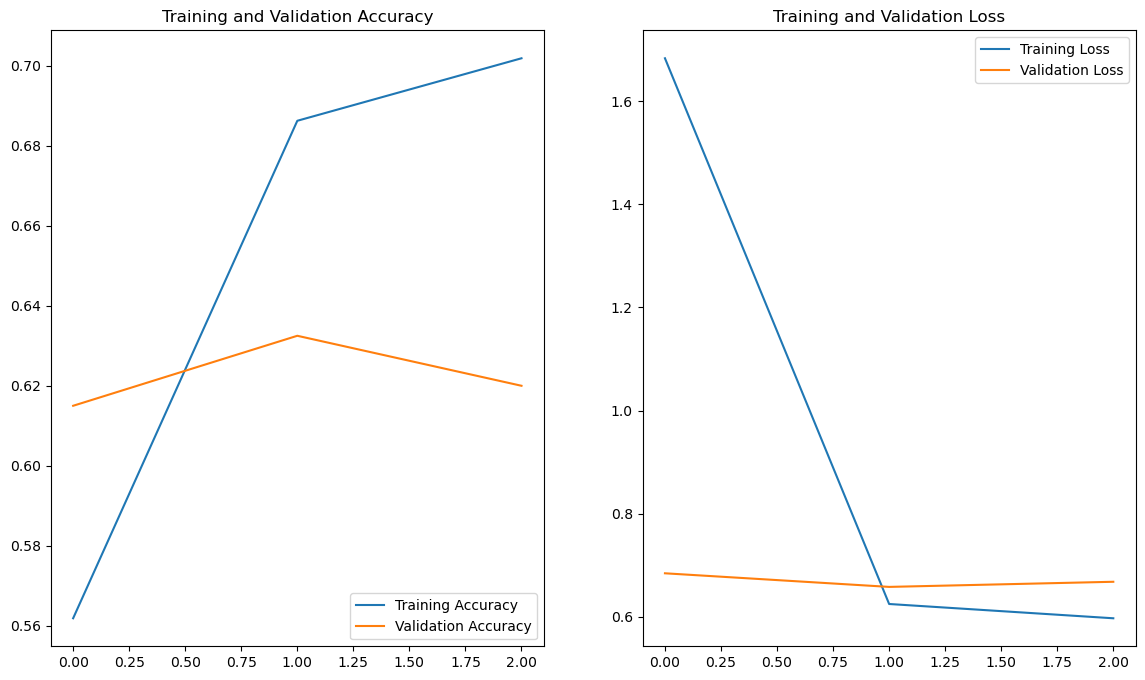

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Hyperparameter tuning

In [15]:
dropout_rates = [0.1, 0.2]
first_filters = [16, 32]
learning_rates = [0.001, 0.0005]
dense_units = [512, 256]

# Define EarlyStopping callback (monitor validation loss, with a patience of 2 epochs)
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

epochs = 2

# Create hyperparameter grid using itertools.product.
hyperparameter_grid = product(dropout_rates, first_filters, learning_rates, dense_units)

results = []  # List to store results from each run.

for dropout_rate, filters, lr, dense_unit in hyperparameter_grid:
    print(f"Running: dropout={dropout_rate}, filters={filters}, lr={lr}, dense_units={dense_unit}")
    
    # Build the model with the current hyperparameters.
    model = custom_CNN(
        (img_height, img_width, channels),
        dropout_rate = dropout_rate,
        filters = filters,
        dense_unit = dense_unit)
    
    # Create optimizer with the given learning rate.
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer,
                  loss=tf.keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    # Train the model.
    history = model.fit(
        train_data_gen,
        steps_per_epoch=total_train // batch_size,
        epochs=epochs,
        validation_data=val_data_gen,
        validation_steps=total_val // batch_size,
        callbacks=[early_stop],
        verbose=0  # Set to 0 to reduce output during tuning.
    )
    
    # Find the best validation accuracy and the corresponding epoch.
    best_val_acc = max(history.history['val_accuracy'])
    best_epoch = history.history['val_accuracy'].index(best_val_acc) + 1
    final_val_loss = history.history['val_loss'][best_epoch - 1]
    
    # Append hyperparameters and performance metrics to the results.
    results.append({
        'dropout_rate': dropout_rate,
        'first_filters': filters,
        'learning_rate': lr,
        'dense_units': dense_unit,
        'best_val_accuracy': best_val_acc,
        'best_epoch': best_epoch,
        'final_val_loss': final_val_loss
    })
    print(f"Completed: best_val_accuracy={best_val_acc:.4f} at epoch {best_epoch}")

# Create a DataFrame from the results and save to CSV.
df_results = pd.DataFrame(results)
csv_filename = "../results/hyperparameter_tuning_results.csv"
df_results.to_csv(csv_filename, index=False)
print(f"Results saved to {csv_filename}")

Running: dropout=0.1, filters=16, lr=0.001, dense_units=512
Completed: best_val_accuracy=0.6425 at epoch 1
Running: dropout=0.1, filters=16, lr=0.001, dense_units=256
Completed: best_val_accuracy=0.6050 at epoch 2
Running: dropout=0.1, filters=16, lr=0.0005, dense_units=512
Completed: best_val_accuracy=0.6125 at epoch 2
Running: dropout=0.1, filters=16, lr=0.0005, dense_units=256
Completed: best_val_accuracy=0.6400 at epoch 2
Running: dropout=0.1, filters=32, lr=0.001, dense_units=512


KeyboardInterrupt: 

## Final baseline model

In [ ]:
results_csv = "../results/hyperparameter_tuning_results.csv"
df_results = pd.read_csv(results_csv)

# Select the best configuration based on highest validation accuracy.
best_config = df_results.sort_values('best_val_accuracy', ascending=False).iloc[0]
best_dropout = best_config['dropout_rate']
best_filters = int(best_config['first_filters'])
best_lr = best_config['learning_rate']
best_dense_units = int(best_config['dense_units'])

print("Best Hyperparameters:")
print(best_config)

best_model = custom_CNN(
    (img_height, img_width, channels),
    dropout_rate = best_dropout,
    filters = best_filters,
    dense_unit = best_dense_unit)

optimizer = Adam(learning_rate=best_lr)
best_model.compile(optimizer=optimizer,
                   loss=tf.keras.losses.BinaryCrossentropy(),
                   metrics=['accuracy'])

best_model.summary()

In [16]:
total_full_train = train_data_gen.samples + val_data_gen.samples
steps_train = train_data_gen.samples // batch_size
steps_val = val_data_gen.samples // batch_size
steps_per_epoch_full = steps_train + steps_val

print(f"Total full training samples: {total_full_train}")
print(f"Steps per epoch: {steps_per_epoch_full}")

Total full training samples: 2000
Steps per epoch: 20


In [ ]:
def combined_generator():
    # Yield batches from the training generator.
    for _ in range(steps_train):
        yield next(train_data_gen)
    # Then yield batches from the validation generator.
    for _ in range(steps_val):
        yield next(val_data_gen)

epochs_full = 10  # Adjust this as needed.

history_full = best_model.fit(
    combined_generator(),
    steps_per_epoch=steps_per_epoch_full,
    epochs=epochs_full,
    verbose=1
)

In [ ]:
# Retrieve only the training history.
acc = history_full.history['accuracy']
loss = history_full.history['loss']
epochs_range = range(epochs_full)

# Plot only the training curves.
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.title('Training Loss')
plt.legend()

plt.show()

In [ ]:
# Define the path where the model will be saved.
model_save_path = "../results/final_baseline.h5"

# Save the retrained model to disk.
best_model.save(model_save_path)

print(f"Model saved to {model_save_path}")

In [ ]:
# Reload the model from disk.
reloaded_model = load_model(model_save_path)
print("Model loaded from disk.")

# Set parameters for the test data generator.
img_height, img_width = 299, 299
batch_size = 100
path_test = "../data/test"

# Compute the number of steps per epoch for the test data.
total_test = test_data_gen.samples
steps_test = total_test // batch_size

# Evaluate the reloaded model on the test set.
test_loss, test_accuracy = reloaded_model.evaluate(test_data_gen, steps=steps_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

In [ ]:
# Create a test data generator with normalization (for evaluation).
test_data_gen_norm = get_image_generator(path_test, img_height, img_width, batch_size, shuffle=False, preprocess=True)

# Determine total number of samples and steps.
total_test = test_data_gen_norm.samples
steps_test = int(np.ceil(total_test / batch_size))

# Generate predictions on the entire test set.
predictions = best_model.predict(test_data_gen_norm, steps=steps_test, verbose=1)
# For binary classification, use a threshold of 0.5.
predictions_class = (predictions > 0.5).astype(int).flatten()

# Get ground truth labels from the generator.
true_labels = test_data_gen_norm.classes

# Compute the confusion matrix.
cm = confusion_matrix(true_labels, predictions_class)
print("Confusion Matrix:")
print(cm)

In [ ]:

# Plot the confusion matrix.
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Create a test data generator WITHOUT normalization (for displaying original images).
test_data_gen_no_norm = get_image_generator(path_test, img_height, img_width, batch_size, shuffle=False, preprocess=False)

# Get one batch of images and their corresponding labels.
images, labels = next(test_data_gen_no_norm)

# Manually normalize the images for evaluation.
images_norm = images.astype('float32') / 255.0

# Get predictions on these normalized images.
preds = best_model.predict(images_norm)
preds_class = (preds > 0.5).astype(int).flatten()

# Plot a few sample images with the predicted labels.
num_images_to_plot = 5
plt.figure(figsize=(15, 3))
for i in range(num_images_to_plot):
    plt.subplot(1, num_images_to_plot, i+1)
    # Display the original (non-normalized) image.
    plt.imshow(images[i].astype("uint8"))
    plt.title(f"Pred: {preds_class[i]}")
    plt.axis('off')
plt.suptitle("Sample Test Images with Model Predictions")
plt.show()